# CS579: Lecture 07  

**Link Prediction**

*[Dr. Aron Culotta](http://cs.iit.edu/~culotta)*  
*[Illinois Institute of Technology](http://iit.edu)*

# Goal:

- Given a graph $G$ at time $t$, predict which edges will be added at time $t+1$.

# Applications?

# Applications?

- Introduce potential friends 
- Introduce potential collaborators
- Recommend a movie

In [1]:
# Let's revisit the co-authorship data.
import networkx as nx
import urllib
# Fetch co-author network from http://snap.stanford.edu/data/ca-GrQc.html
urllib.urlretrieve ("http://snap.stanford.edu/data/ca-GrQc.txt.gz", "ca-GrQc.txt.gz")
graph = nx.read_edgelist('ca-GrQc.txt.gz')

In [10]:
degrees = graph.degree()
author = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[500][0]
print 'selected author %s with degree %d' % (author, graph.degree(author))

selected author 18743 with degree 13


In [3]:
def get_subgraph(graph, node, n=100):
    """ Get the subgraph consisting of this node and its neighbors,
    and their neighbors, up to $n$ total nodes"""
    neighbors = graph.neighbors(node)
    result = set([node])
    for x in neighbors:
        maxsize = n - len(result)
        toadd = set(graph.neighbors(x)) - result
        result.update(list(toadd)[:maxsize])
        if len(result) > n:
            break
    return graph.subgraph(result)

subgraph = get_subgraph(graph, author, n=30)
print 'subgraph has %d nodes' % len(subgraph.nodes())

subgraph has 28 nodes


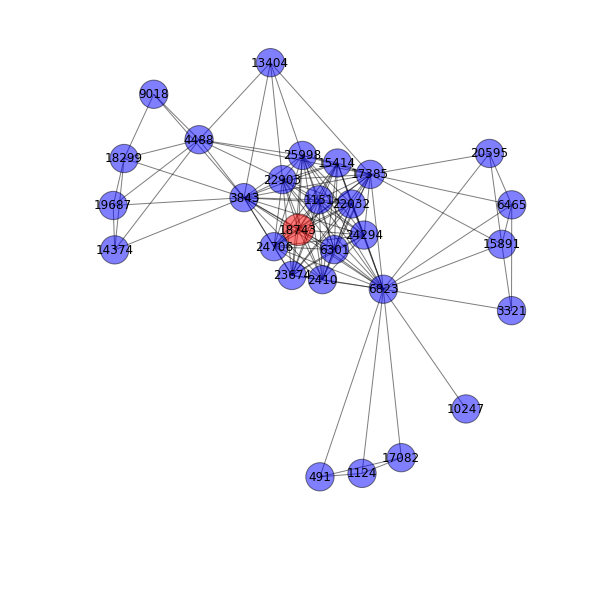

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_subgraph(subgraph, node):
    nodes = subgraph.nodes()
    idx = nodes.index(node)
    colors = ['b'] * len(nodes)
    colors[idx] = 'r'
    sizes = [800] * len(nodes)
    sizes[idx] = 1000
    plt.figure(figsize=(10,10))
    plt.axis('off')
    nx.draw_networkx(subgraph, nodelist=nodes, with_labels=True,
                     width=1, node_color=colors,
                     node_size=sizes, alpha=.5)

plot_subgraph(subgraph, author)

# Approaches


Score each possible new edge $s(X,Y)$.

Higher $s(X,Y)$ $\rightarrow$ more likely for the edge to appear.


# Approaches


Score each possible new edge $s(X,Y)$.

Higher $s(X,Y)$ $\rightarrow$ more likely for the edge to appear.

1.) **Shortest Path:** $s(X,Y) = $ length of shortest path from $X$ to $Y$.

Disadvantages?

In [14]:
from pprint import pprint  # I'm using this to print list of tuples in a more readable way.

def rank_by_shortest_path(graph, node):
    paths = nx.shortest_path_length(graph, node)
    return sorted(paths.items(), key=lambda x: x[1])

shortest_paths = rank_by_shortest_path(graph, author)
pprint([s for s in shortest_paths if s[1] == 2])
# Many shortest paths of length 2!

[(u'3321', 2),
 (u'10247', 2),
 (u'1124', 2),
 (u'9018', 2),
 (u'13404', 2),
 (u'17082', 2),
 (u'20595', 2),
 (u'6465', 2),
 (u'491', 2),
 (u'19687', 2),
 (u'14374', 2),
 (u'4488', 2),
 (u'18299', 2),
 (u'15891', 2)]


# Approaches

**Idea:** If $X$ and $Y$ have many co-authors who have co-authored, then $X$ and $Y$ are more likely to co-author.

 2.) **Common Neighbors:** $$|N(X) \cap N(Y)|$$

In [16]:
from collections import Counter

def rank_by_common_neighbors(graph, node):
    neighbors = set(graph.neighbors(node))
    scores = []
    for n in graph.nodes():
        neighbors2 = set(graph.neighbors(n))
        scores.append((n, len(neighbors & neighbors2)))
    return sorted(scores, key=lambda x: x[1], reverse=True)
common_neighbors = rank_by_common_neighbors(graph, author)
print 'Histogram of number of nodes with common neighbors:\n', \
    Counter([x[1] for x in common_neighbors if x[1] > 1])

Histogram of number of nodes with common neighbors:
Counter({12: 13, 2: 3, 4: 2, 13: 1})


# Approaches

**Idea:** If $X$ and $Y$ have many co-authors who have co-authored, then $X$ and $Y$ are more likely to co-author.

 3.) **Jaccard coefficient:** $$\frac{|N(X) \cap N(Y)|}{|N(X) \cup N(Y)|}$$
 
 For a randomly selected node $Z \in N(X) \cup N(Y)$, how likely is it that $Z$ is in both $N(X)$ and $N(Y)$?

In [17]:
def rank_by_jaccard(graph, node):
    neighbors = set(graph.neighbors(node))
    scores = []
    for n in graph.nodes():
        neighbors2 = set(graph.neighbors(n))
        scores.append((n, 1. * len(neighbors & neighbors2) / 
                               len(neighbors | neighbors2)))
    return sorted(scores, key=lambda x: x[1], reverse=True)

common_jaccard = rank_by_jaccard(graph, author)
pprint(common_jaccard[:20])

[(u'18743', 1.0),
 (u'1151', 0.8571428571428571),
 (u'22032', 0.8571428571428571),
 (u'23674', 0.8571428571428571),
 (u'24294', 0.8571428571428571),
 (u'24706', 0.8571428571428571),
 (u'2410', 0.8571428571428571),
 (u'6301', 0.8571428571428571),
 (u'15414', 0.8571428571428571),
 (u'22903', 0.75),
 (u'25998', 0.75),
 (u'17385', 0.631578947368421),
 (u'3843', 0.6),
 (u'6823', 0.5454545454545454),
 (u'4488', 0.2222222222222222),
 (u'13404', 0.16),
 (u'6465', 0.125),
 (u'15891', 0.125),
 (u'20595', 0.1),
 (u'10247', 0.07692307692307693)]


# Approaches

 4.) **Preferential attachment:** $$|N(X)| \times |N(Y)|$$

# Approaches

**Idea:** two nodes are similar if they have similar neighbors

 5.) **SimRank:** $$s(X,Y) = \gamma \frac{\sum_{A \in N(X)} \sum_{B \in N(Y)}s(A,B)}{|N(X)| \cdot |N(Y)|}$$
 
 $\gamma \in [0, 1]$ is a tuning parameter.

# Evaluation

**How can I tell which method is best?**

# Train/Test evaluation

1. Create $G'$ by removing $n$ edges $E$ from $G$ at random.
  - $G'$ is the **training** network
  - $G$ is the **testing** network
2. Score all potential edges to add in $G'$.
3. Return $\hat{E}$, the top $n$ edges with highest score.
4. Compute the fraction of predicted edges that are in $G$:
$$\frac{|\hat{E} \cap E|}{|E|}$$

In [18]:
# Evaluate Jaccard using train/test
import random
random.seed(123)

def sample_edges(graph, node, pct=.5):
    """ Randomly remove some edges for node.
    Return:
      the resulting graph G'
      the list of friends of node whose edges were removed.
    """
    edges = graph.edges([node])
    # Sample edges to remove.
    to_remove = random.sample(edges, int(len(edges) * pct))
    # Create the list of friends whose edges we have removed.
    friends = []
    for x in to_remove:
        if x[0] != node:
            friends.append(x[0])
        else:
            friends.append(x[1])
    print 'removing %d edges' % len(to_remove)
    # Copy G into G' and remove the edges.
    graph_cp = graph.copy()
    graph_cp.remove_edges_from(to_remove)
    return graph_cp, friends

train_graph, friends = sample_edges(graph, author)
prediction = rank_by_jaccard(train_graph, author)[1:7]
print 'jaccard rank=', prediction
print 'true neighbors=', friends
n_correct = len(set(friends) & set([x[0] for x in prediction]))
print 'Jaccard finds %d/%d for accuracy of %.3f' % (n_correct, len(friends), (1. * n_correct / len(friends)))

removing 6 edges
jaccard rank= [(u'1151', 0.5833333333333334), (u'22032', 0.5833333333333334), (u'24294', 0.5833333333333334), (u'24706', 0.5833333333333334), (u'23674', 0.42857142857142855), (u'15414', 0.42857142857142855)]
true neighbors= [u'22032', u'6823', u'1151', u'24294', u'24706', u'17385']
Jaccard finds 4/6 for accuracy of 0.667
